Sentiment Analysis - Amazon Customer Reviews


Sanjiv Motilal Choudhari


# Objective

This notebook performs a comprehensive analysis of Amazon customer reviews to understand customer sentiment and feedback on products. It begins by loading and preprocessing the review data, cleaning and preparing it for analysis. Then, it uses Natural Language Processing (NLP) techniques like sentiment analysis and key phrase extraction to categorize reviews and identify important topics. It further summarizes feedback, aggregates insights by product category, and visualizes the results through word clouds, bar charts, and heatmaps. Ultimately, the objective is to gain actionable insights into customer satisfaction, product strengths and weaknesses, and overall sentiment trends, enabling informed decision-making for product improvement and business strategies.

#1. Data Loading and Setup

Loads the dataset into a PySpark DataFrame, displays its schema, and previews a few rows to understand the structure.
Ensures the data is properly loaded and ready for processing.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("datafiniti/consumer-reviews-of-amazon-products")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/datafiniti/consumer-reviews-of-amazon-products/versions/5


In [ ]:
import os
print(os.listdir(path))  # List all files and subfolders in the downloaded path


['Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv', '1429_1.csv', 'Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv']


In [ ]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Customer Feedback Analysis") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

# Define file path (update based on actual file in the downloaded folder)
file_path = f"{path}/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv"  #28,000 comments
# Load the dataset
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Display the structure of the dataset
data.printSchema()

root
 |-- id: string (nullable = true)
 |-- dateAdded: timestamp (nullable = true)
 |-- dateUpdated: timestamp (nullable = true)
 |-- name: string (nullable = true)
 |-- asins: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- primaryCategories: string (nullable = true)
 |-- imageURLs: string (nullable = true)
 |-- keys: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- manufacturerNumber: string (nullable = true)
 |-- reviews.date: string (nullable = true)
 |-- reviews.dateSeen: string (nullable = true)
 |-- reviews.didPurchase: string (nullable = true)
 |-- reviews.doRecommend: boolean (nullable = true)
 |-- reviews.id: string (nullable = true)
 |-- reviews.numHelpful: integer (nullable = true)
 |-- reviews.rating: integer (nullable = true)
 |-- reviews.sourceURLs: string (nullable = true)
 |-- reviews.text: string (nullable = true)
 |-- reviews.title: string (nullable = true)
 |-- reviews.username: st

# 2. Data Preprocessing

Cleans text by converting to lowercase, removing punctuation, tokenizing into words, and filtering out stop words.
Prepares the text data for analysis by removing noise and splitting it into meaningful tokens.

In [ ]:
data.show(5)

+--------------------+-------------------+-------------------+--------------------+--------------------+------------+--------------------+-----------------+--------------------+--------------------+------------+------------------+--------------------+--------------------+-------------------+-------------------+----------+------------------+--------------+--------------------+--------------------+--------------------+----------------+--------------------+
|                  id|          dateAdded|        dateUpdated|                name|               asins|       brand|          categories|primaryCategories|           imageURLs|                keys|manufacturer|manufacturerNumber|        reviews.date|    reviews.dateSeen|reviews.didPurchase|reviews.doRecommend|reviews.id|reviews.numHelpful|reviews.rating|  reviews.sourceURLs|        reviews.text|       reviews.title|reviews.username|          sourceURLs|
+--------------------+-------------------+-------------------+--------------------

In [ ]:
from pyspark.sql.functions import col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover

# Step 2.1: Clean text - lowercase and remove punctuation
clean_data = data.withColumn("cleaned_review", lower(col("`reviews.text`")))  # Accessing 'reviews.text' correctly
clean_data = clean_data.withColumn("cleaned_review", regexp_replace(col("cleaned_review"), "[^a-zA-Z\\s]", ""))

# Step 2.2: Tokenize the cleaned text
tokenizer = Tokenizer(inputCol="cleaned_review", outputCol="tokens")
tokenized_data = tokenizer.transform(clean_data)

# Step 2.3: Remove stop words
stopword_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
filtered_data = stopword_remover.transform(tokenized_data)

# Show the processed data (review text, cleaned review, and filtered tokens)
filtered_data.select("`reviews.text`", "cleaned_review", "filtered_tokens").show(5, truncate=False)


+-------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|reviews.text                                                                                                                               |cleaned_review                                                                                                                          |filtered_tokens                                                                                     |
+-------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------

# 3. Sentiment Analysis and Key Phrase Extraction

Adds a sentiment column based on star ratings and extracts key phrases using a CountVectorizer to identify frequently occurring words.
Classifies reviews into positive, neutral, and negative sentiments while identifying key topics from the feedback.

In [ ]:
from pyspark.sql.functions import when
from pyspark.ml.feature import CountVectorizer

# Step 3.1: Sentiment Analysis - Add sentiment column based on 'reviews.rating'
filtered_data = filtered_data.withColumn(
    "sentiment",
    when(col("`reviews.rating`") >= 4, "positive")
    .when(col("`reviews.rating`") <= 2, "negative")
    .otherwise("neutral")
)

# Step 3.2: Key Phrase Extraction using CountVectorizer
vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="features")
vectorizer_model = vectorizer.fit(filtered_data)
key_phrase_data = vectorizer_model.transform(filtered_data)

# Show key phrases and their frequency
key_phrase_data.select("filtered_tokens", "features").show(5, truncate=False)

+----------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------+
|filtered_tokens                                                                                     |features                                                                                                                         |
+----------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------+
|[order, , one, item, bad, quality, missing, backup, spring, put, pcs, aluminum, make, battery, work]|(11973,[1,12,17,25,39,96,150,162,223,258,1233,1248,2114,3639,5545],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|[bulk, always, less, expensive, way, go, products, like]           

# 4. Summarization

Summarizes feedback for each sentiment by selecting and displaying key phrases from positive and negative reviews.
Highlights critical insights from the feedback for different sentiment categories.



In [ ]:
# Step 4: Summarize reviews based on sentiment
def summarize_reviews(df, sentiment_label):
    # Filter the data based on the sentiment label
    summary = df.filter(col("sentiment") == sentiment_label)

    # Show review text and filtered tokens for the specific sentiment
    summary.select(col("`reviews.text`"), "filtered_tokens").show(5, truncate=False)

# Summarize positive reviews
print("Positive Reviews Summary:")
summarize_reviews(key_phrase_data, "positive")

# Summarize negative reviews
print("Negative Reviews Summary:")
summarize_reviews(key_phrase_data, "negative")

Positive Reviews Summary:
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|reviews.text                                                                                                                                                                                                                                                              |filtered_tokens                                                                                                                                                                          |
+---------------------------------------------------------------

# 5. Aggregation and Insights

Groups the data by product category and sentiment, providing an overview of sentiment trends across categories.
Identifies areas of improvement and strengths based on customer feedback patterns.

In [ ]:
# Step 5: Group data by 'categories' (or 'primaryCategories') and 'sentiment'
insights = key_phrase_data.groupBy("categories", "sentiment").count()  # Replace 'categories' if needed

# Display the insights
insights.show(10)

# Save insights to a CSV file
insights.write.csv("/content/drive/MyDrive/dataset/customer_feedback_insights.csv", header=True)

+--------------------+---------+-----+
|          categories|sentiment|count|
+--------------------+---------+-----+
|Portable Computer...|  neutral|    3|
|Crate Training,Cr...| positive|    1|
|Computers & Acces...|  neutral|    2|
|Fire Tablets,Tabl...| negative|   62|
|Fire Tablets,Comp...|  neutral|   10|
|eBook Readers,Ele...| positive|  487|
|Amazon Echo,Smart...| positive|    5|
|Fire Tablets,Comp...|  neutral|   80|
|AA,AAA,Electronic...|  neutral|  175|
|Portable Computer...| positive|    3|
+--------------------+---------+-----+
only showing top 10 rows



# Visualization

Generates word clouds for positive and negative reviews, visualizing frequently occurring words in each category.
Provides a quick and visually appealing representation of key phrases and themes in the feedback.

In [ ]:
!pip install wordcloud matplotlib pyspark

In [ ]:
from pyspark.sql.functions import explode, col

# Step 1: Extract positive and negative reviews based on sentiment
positive_reviews = key_phrase_data.filter(col("sentiment") == "positive")
negative_reviews = key_phrase_data.filter(col("sentiment") == "negative")

# Step 2: Explode filtered_tokens into individual words
positive_words = positive_reviews.select(explode(col("filtered_tokens")).alias("word"))
negative_words = negative_reviews.select(explode(col("filtered_tokens")).alias("word"))

# Step 3: Count frequency of each word
positive_word_counts = positive_words.groupBy("word").count().orderBy(col("count").desc())
negative_word_counts = negative_words.groupBy("word").count().orderBy(col("count").desc())

# Convert to Pandas DataFrames for easier handling and visualization
positive_word_counts_df = positive_word_counts.toPandas()
negative_word_counts_df = negative_word_counts.toPandas()


In [ ]:
# Show the top 5 most frequent words
print("Top 5 Positive Words:\n")
print(positive_word_counts_df.head(5))
print("\n=========================\n")
print("Top 5 Negative Words:\n")
print(negative_word_counts_df.head(5))

Top 5 Positive Words:

        word  count
0      great   9019
1              6790
2  batteries   6389
3     tablet   5968
4       good   5296


Top 5 Negative Words:

        word  count
0  batteries   1292
1              1128
2       last    417
3     amazon    381
4       dont    319


Plots a bar chart of the count of reviews for each sentiment. Shows the overall distribution of sentiments in the dataset

  sentiment  count
0  positive  25454
1   neutral   1205
2  negative   1673


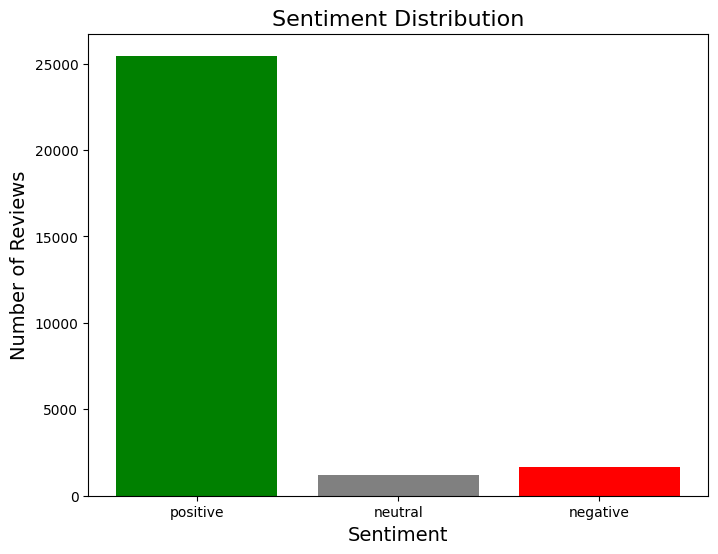

In [ ]:
import matplotlib.pyplot as plt

# Convert sentiment counts to Pandas
sentiment_distribution = key_phrase_data.groupBy("sentiment").count().toPandas()

# Ensure there are valid sentiment labels in the dataset
print(sentiment_distribution)

# Plot the sentiment distribution
plt.figure(figsize=(8, 6))
plt.bar(sentiment_distribution['sentiment'], sentiment_distribution['count'], color=['green', 'gray', 'red'])

# Add title and labels
plt.title("Sentiment Distribution", fontsize=16)
plt.xlabel("Sentiment", fontsize=14)
plt.ylabel("Number of Reviews", fontsize=14)

# Show the plot
plt.show()

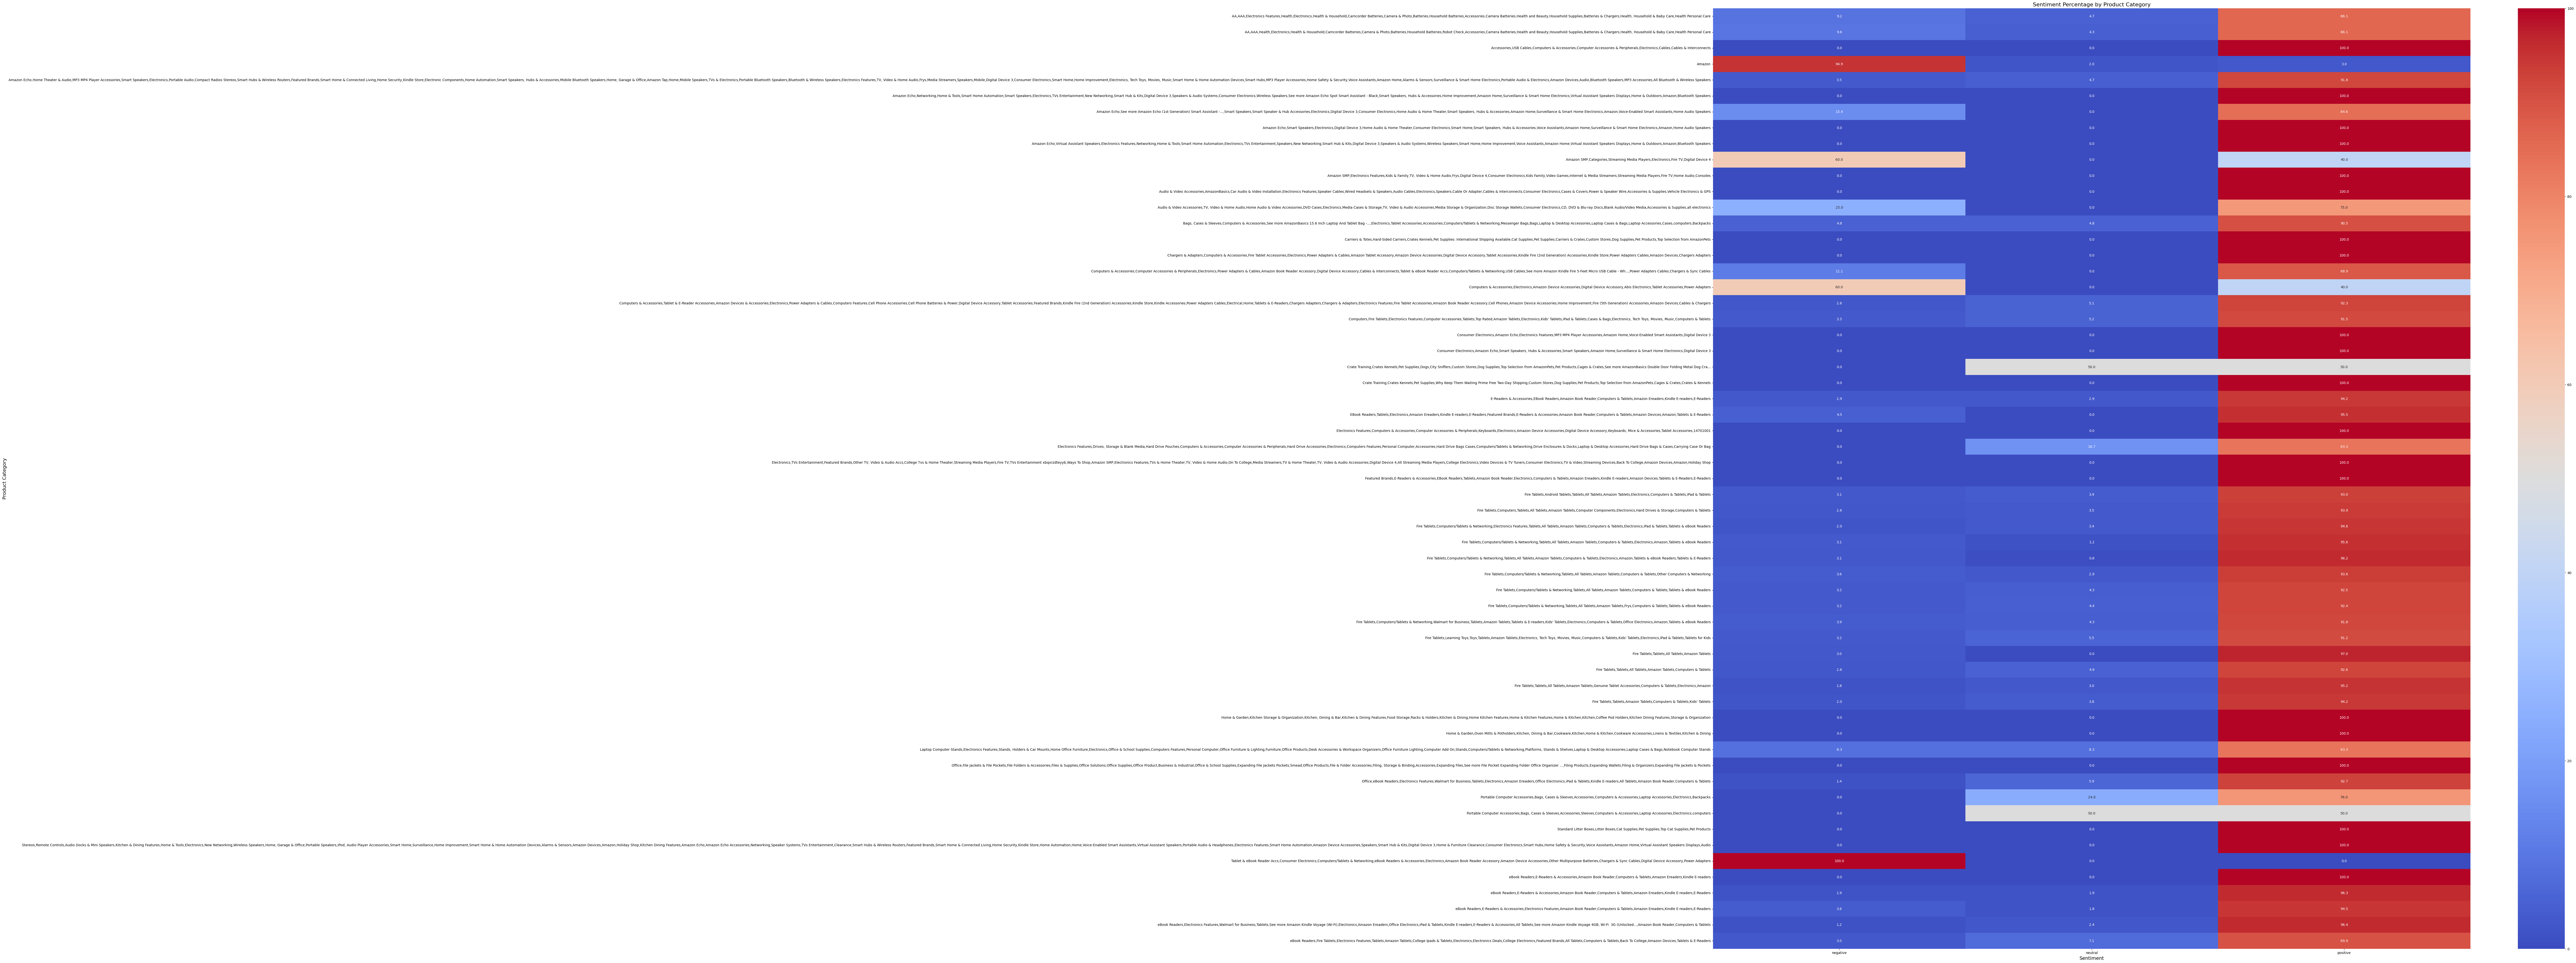

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Calculate sentiment percentage by dividing each category sentiment count by the sum of counts in each product category (row-wise)
category_sentiment_pivot_percentage = category_sentiment_pivot.div(category_sentiment_pivot.sum(axis=1), axis=0) * 100

# Step 2: Plot the heatmap
plt.figure(figsize=(50, 50))

# Create heatmap with percentage values
sns.heatmap(category_sentiment_pivot_percentage, annot=True, fmt=".1f", cmap="coolwarm")

# Customize the plot
plt.title("Sentiment Percentage by Product Category", fontsize=16)
plt.xlabel("Sentiment", fontsize=14)
plt.ylabel("Product Category", fontsize=14)

# Show the heatmap
plt.show()


Plots bar charts for the top 10 most frequent words in positive and negative reviews.
Identifies the most mentioned themes and issues in customer feedback.

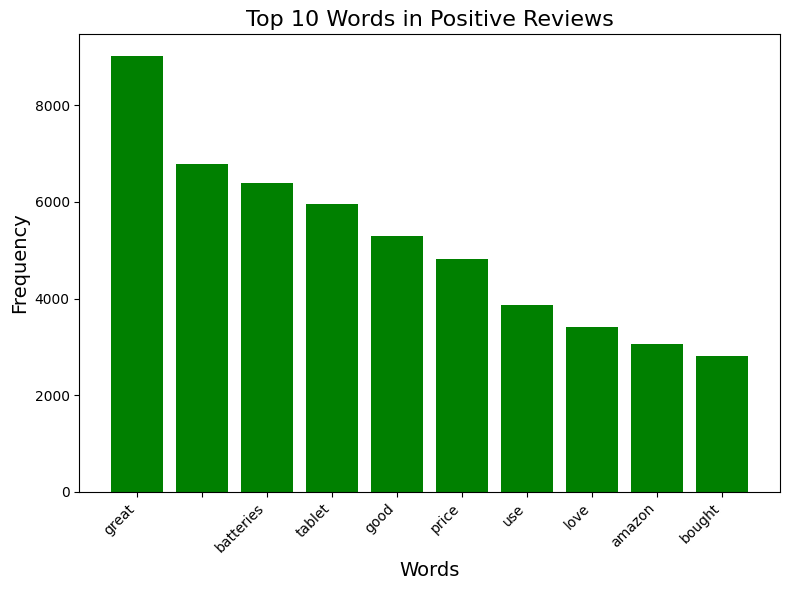

In [ ]:
# Extract top 10 words for positive reviews by sorting by frequency
top_positive_words = positive_word_counts_df.sort_values(by='count', ascending=False).head(10)

# Plot
plt.figure(figsize=(8, 6))
plt.bar(top_positive_words['word'], top_positive_words['count'], color='green')
plt.title("Top 10 Words in Positive Reviews", fontsize=16)
plt.xlabel("Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

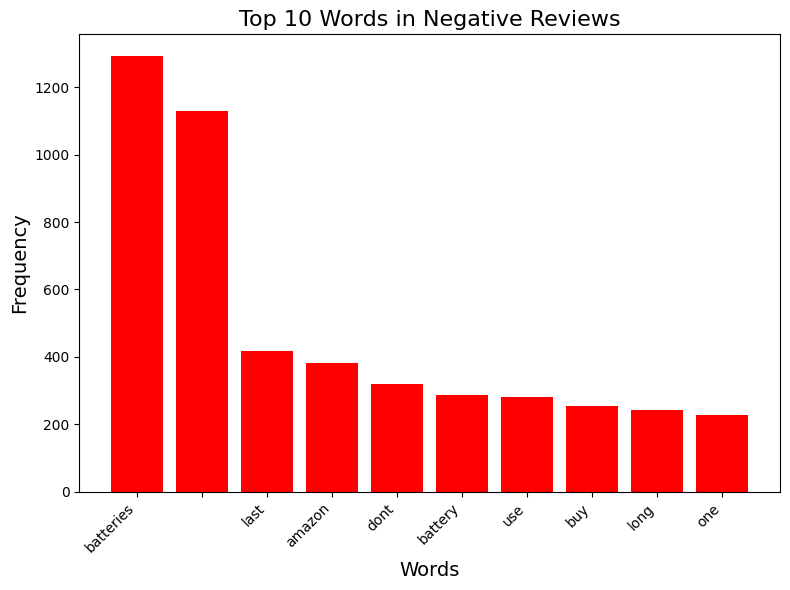

In [ ]:
# Extract top 10 words for negative reviews by sorting by frequency
top_negative_words = negative_word_counts_df.sort_values(by='count', ascending=False).head(10)

# Plot
plt.figure(figsize=(8, 6))
plt.bar(top_negative_words['word'], top_negative_words['count'], color='red')
plt.title("Top 10 Words in Negative Reviews", fontsize=16)
plt.xlabel("Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()


Plots a line chart to show the trend of sentiments over time.
Analyzes how customer satisfaction changes over time, indicating potential seasonal patterns or product improvements.

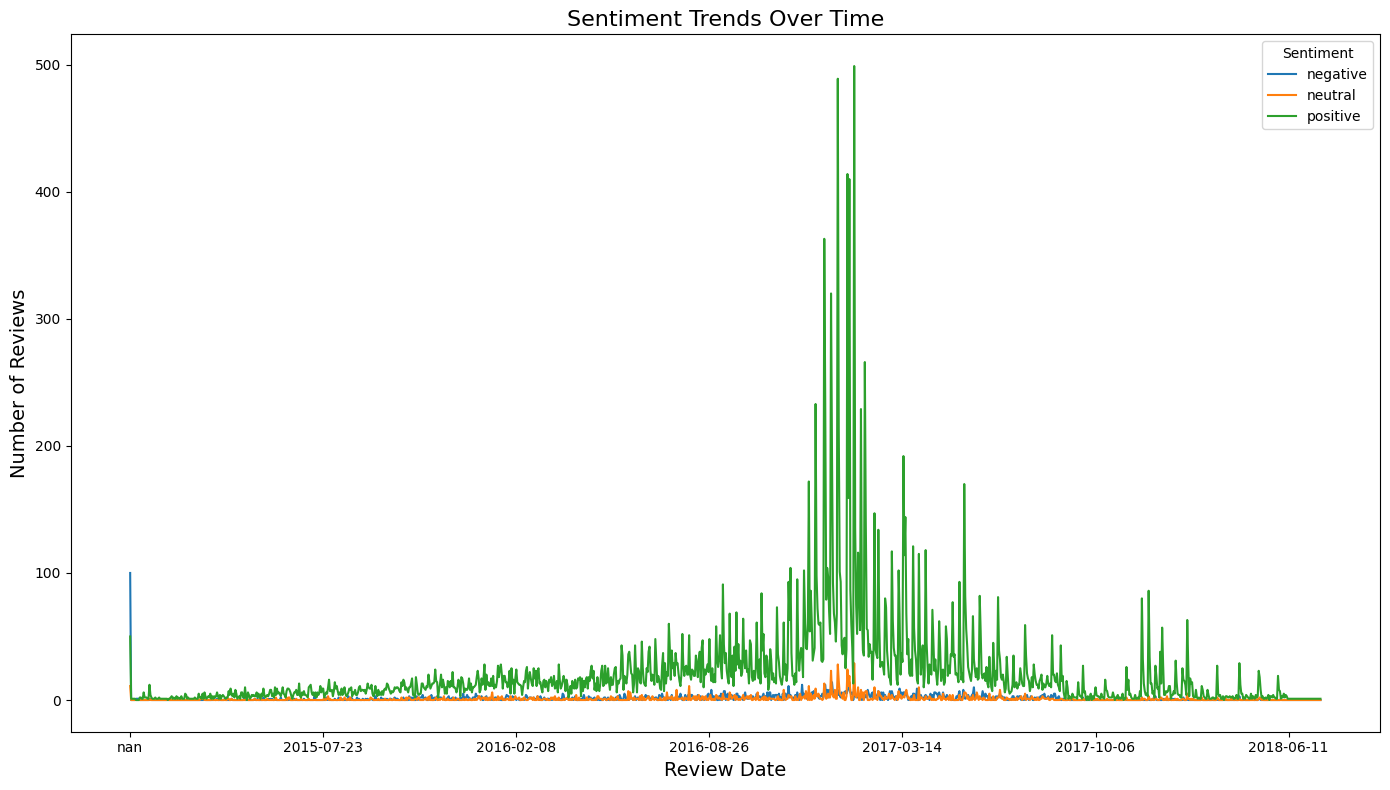

In [ ]:
from pyspark.sql.functions import to_date, col, to_timestamp
import pandas as pd
import matplotlib.pyplot as plt

# Replace 'reviews.date' or 'dateAdded' with the actual column name from your DataFrame
date_column_name = 'reviews.date'  # or 'dateAdded' if that's the correct name

# Convert the date column to date format
# Use to_timestamp to parse the ISO 8601 format, then cast to date
key_phrase_data = key_phrase_data.withColumn(
    "review_date",
    to_date(to_timestamp(col("`"+date_column_name+"`"), "yyyy-MM-dd'T'HH:mm:ss.SSS'Z'"))
    # Adjust format if needed
)

# Group data by review date and sentiment
time_sentiment = key_phrase_data.groupBy("review_date", "sentiment").count().toPandas()

# Pivot the data for time-series plotting
time_sentiment_pivot = time_sentiment.pivot(index='review_date', columns='sentiment', values='count').fillna(0)

# Plot the time-series data
time_sentiment_pivot.plot(figsize=(14, 8))
plt.title("Sentiment Trends Over Time", fontsize=16)
plt.xlabel("Review Date", fontsize=14)
plt.ylabel("Number of Reviews", fontsize=14)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

**Distribution of Rating**

This bar chart displays the distribution of star ratings in the dataset. It shows the frequency of each rating, indicating the overall customer satisfaction level.

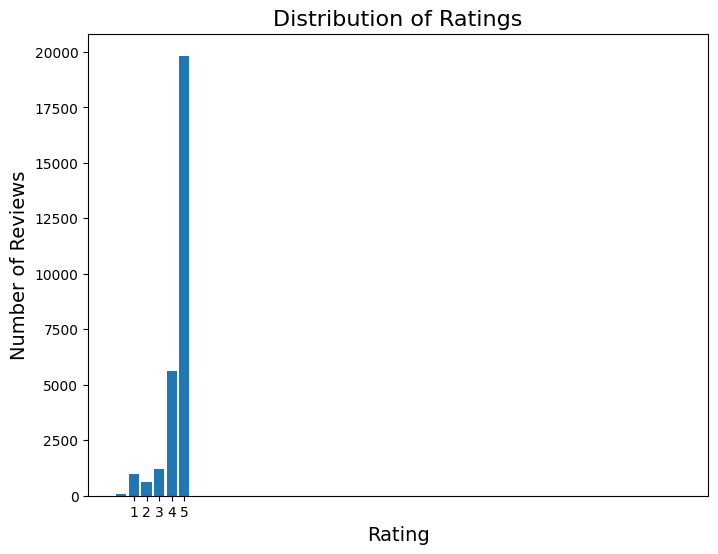

In [ ]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'key_phrase_data'
ratings_distribution = key_phrase_data.groupBy("`reviews.rating`").count().toPandas()

plt.figure(figsize=(8, 6))
plt.bar(ratings_distribution['reviews.rating'], ratings_distribution['count'])
plt.title("Distribution of Ratings", fontsize=16)
plt.xlabel("Rating", fontsize=14)
plt.ylabel("Number of Reviews", fontsize=14)
plt.xticks(range(1,6))
plt.show()

**Average Rating per Category**

This bar chart illustrates the average rating for each product category. It helps compare customer satisfaction across different product categories.

<ipython-input-59-457727164043>:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


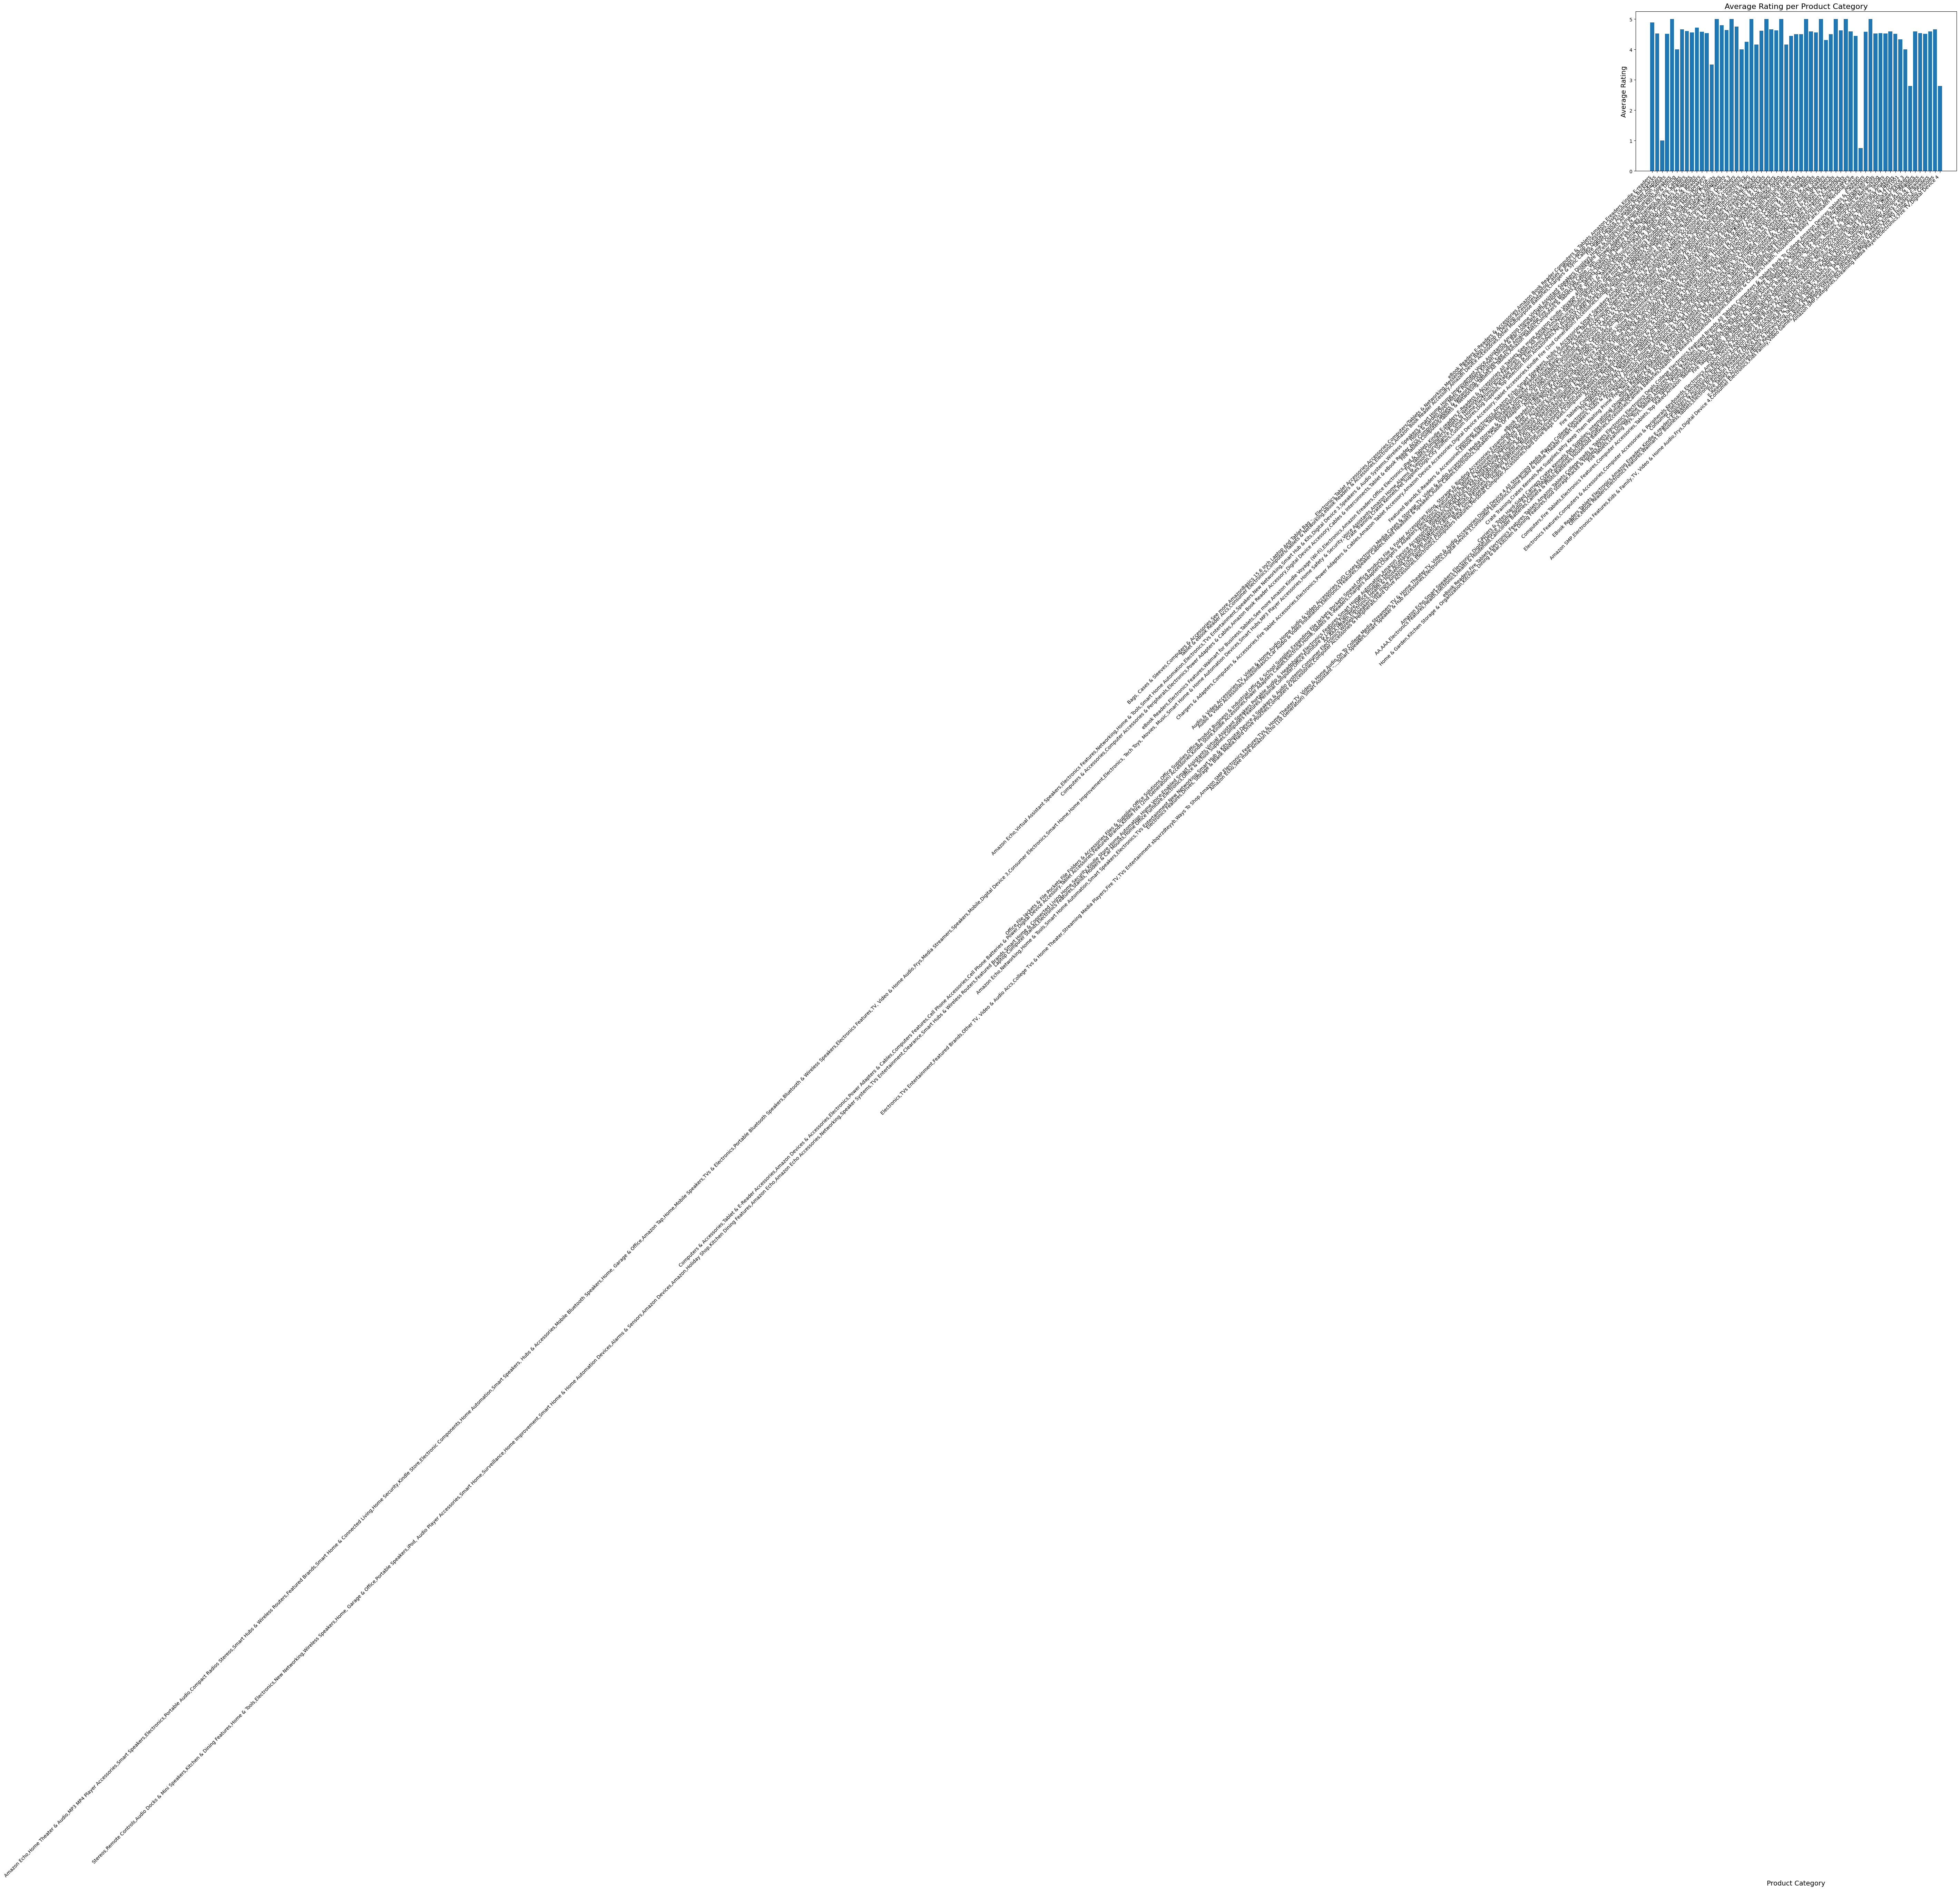

In [ ]:
import matplotlib.pyplot as plt

avg_ratings_by_category = key_phrase_data.groupBy("categories").avg("`reviews.rating`").toPandas()

# Access the average rating column using its actual name in the Pandas DataFrame
avg_rating_column_name = avg_ratings_by_category.columns[1]
plt.figure(figsize=(12, 6))
plt.bar(avg_ratings_by_category['categories'], avg_ratings_by_category[avg_rating_column_name])
plt.title("Average Rating per Product Category", fontsize=16)
plt.xlabel("Product Category", fontsize=14)
plt.ylabel("Average Rating", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Correlation between review length and rating provided**

This scatter plot explores the relationship between review length and star ratings. It helps identify if longer or shorter reviews tend to have higher or lower ratings.

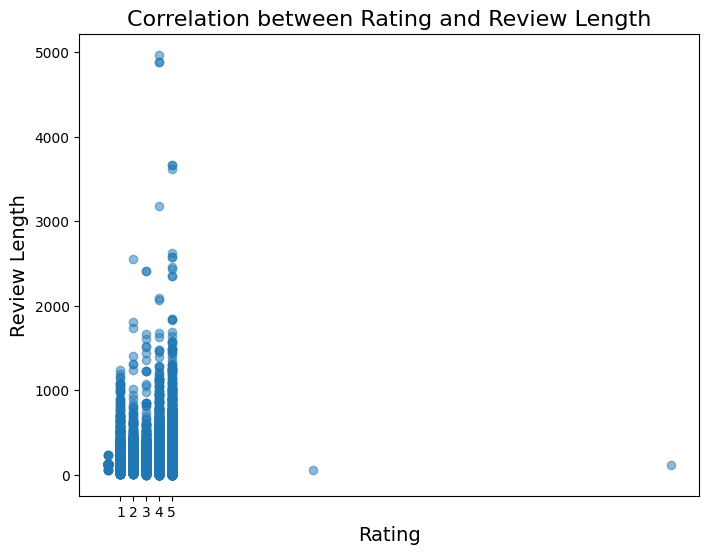

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import length

key_phrase_data = key_phrase_data.withColumn("review_length", length(col("`reviews.text`")))
rating_vs_length = key_phrase_data.select("`reviews.rating`", "review_length").toPandas()

plt.figure(figsize=(8, 6))
plt.scatter(rating_vs_length['reviews.rating'], rating_vs_length['review_length'], alpha=0.5)
plt.title("Correlation between Rating and Review Length", fontsize=16)
plt.xlabel("Rating", fontsize=14)
plt.xticks(range(1,6))
plt.ylabel("Review Length", fontsize=14)
plt.show()

Uses a grouped bar chart and heatmap to visualize the frequency and percentage of sentiments for each product category.
Reveals which categories have the most positive or negative feedback, aiding in targeted analysis.



<ipython-input-39-5ee6c91aa8ab>:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


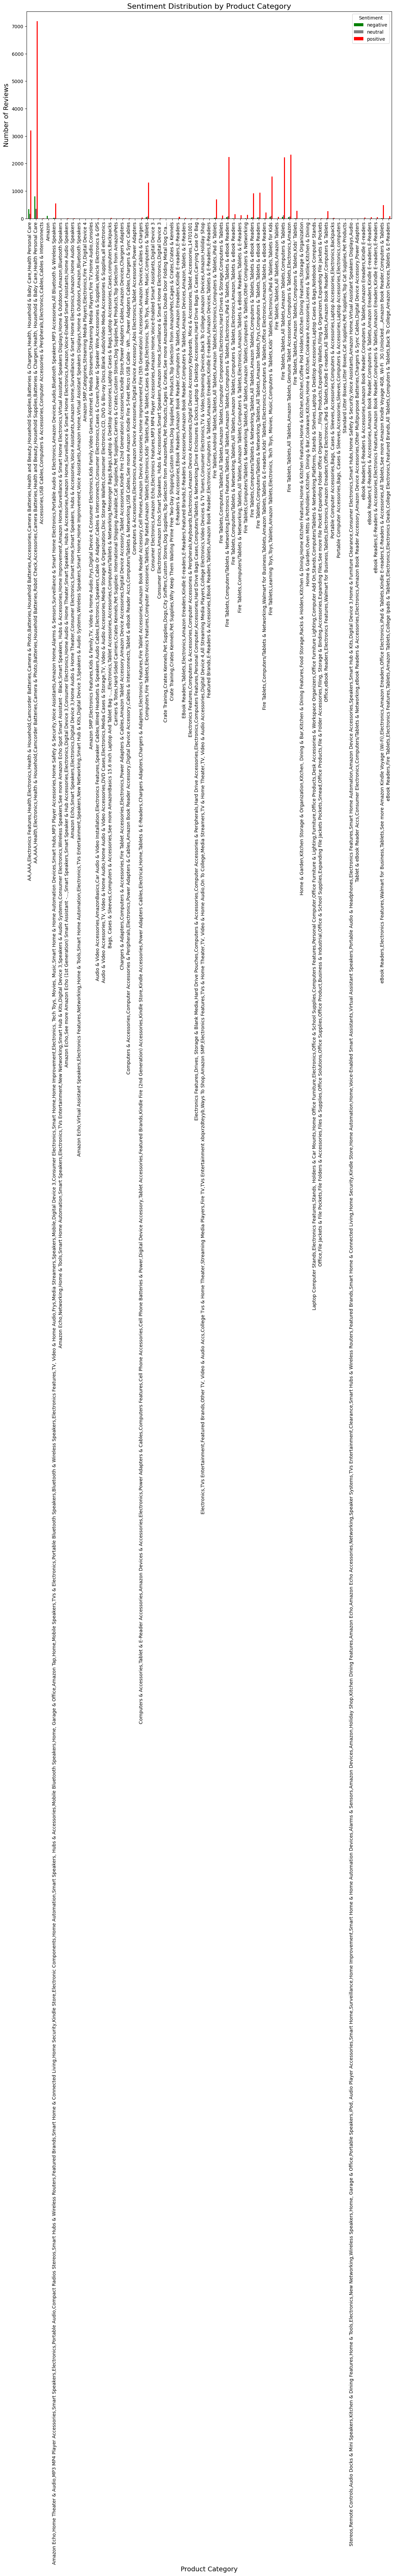

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group data by product category and sentiment
category_sentiment = key_phrase_data.groupBy("categories", "sentiment").count().toPandas()  # Adjust 'categories' if necessary

# Pivot the data for easier plotting
category_sentiment_pivot = category_sentiment.pivot(index='categories', columns='sentiment', values='count').fillna(0)

# Plot grouped bar chart
category_sentiment_pivot.plot(kind='bar', figsize=(14, 8), stacked=False, color=['green', 'gray', 'red'])

# Customize the plot
plt.title("Sentiment Distribution by Product Category", fontsize=16)
plt.xlabel("Product Category", fontsize=14)
plt.ylabel("Number of Reviews", fontsize=14)
plt.legend(title="Sentiment")

# Adjust layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import concat_ws, col, length

# Create or get a SparkSession
spark = SparkSession.builder.appName("SummarizeFeedback").getOrCreate()

def summarize_feedback(tokens):
    """Joins the tokens into a string to create a summary."""
    return concat_ws(" ", tokens)

# Assuming key_phrase_data is a Spark DataFrame
# Create a new column with summarized feedback
summarized_data = key_phrase_data.withColumn(
    "summarized_feedback", summarize_feedback(col("filtered_tokens"))
)

# Select the desired columns
final_dataset = summarized_data.select(
    "filtered_tokens", "sentiment", "summarized_feedback"
)

# Stop the SparkSession when done
spark.stop()

ConnectionRefusedError: [Errno 111] Connection refused

In [ ]:
final_dataset.show(5)  # Shows the first 5 rows

In [ ]:
final_dataset.write.csv("/content/drive/MyDrive/dataset/summarized_dataset.csv", header=True)